This document contains: <br>
1. Description of the data created for the study Trcka et al. 2022
2. Script to generate the <a href="https://skirt.ugent.be/root/_landing.html">SKIRT</a> configuration file for an arbitrary TNG galaxy 

# TNG50 dust attenuated fluxes 

## Data description
<u><b>File name: </b></u> <br>
TNG{<b>simulation run</b>}\_{<b>simulation resolution</b>}\_{<b>data type</b>}\_{<b>redshift</b>}\_{<b>orientation</b>}\_{<b>aperture</b>}.hdf5 <br>


<u><b>Options:</b></u><br>
<b>simulation run:</b> 50, 100 <br>
<b>simulation resolution:</b> 1, 2<br>
<b>data type:</b> seds, bands <br>
<b>redshift:</b> z0, z01 <br>
<b>orientation:</b> random, faceon, edgeon <br>
<b>aperture:</b> 2R, 5R, 10kpc, 30kpc <br>

<u><b>File structure:</b></u><br>
1. seds: In each file there is a dataset per galaxy with the following structure:

|wavelength [micron]|total flux [Jy] |
|-----|-----|
|...|...|

2. bands: Absolute magnitudes and Flux [Jy] in the observed frame for 53 bands. Table below lists the flux labels and the corresponding wavelengths. To extract absolute magnitudes "F_" should be replaced with "M_" 

|flux label  |wavelength|  ***   |flux label  |wavelength|  ***   |flux label  |wavelength|
|------------|----------|--------|------------|----------|--------|------------|----------|
|F_GALEX_FUV |0.1535    |        |F_Johnson_R |0.6899    |        |F_MIPS_160  |156.4     |
|F_GALEX_NUV |0.2301    |        |F_Johnson_I |0.8739    |        |F_PACS_70   |70.77     |
|F_SDSS_u    |0.3557    |        |F_Johnson_J |1.243     |        |F_PACS_100  |100.8     |
|F_SDSS_g    |0.4702    |        |F_Johnson_M |5.012     |        |F_PACS_160  |161.9     |
|F_SDSS_r    |0.6176    |        |F_WISE_W1   |3.39      |        |F_SPIRE_250 |252.5     |
|F_SDSS_i    |0.749     |        |F_WISE_W2   |4.6410    |        |F_SPIRE_350 |54.3      |
|F_SDSS_z    |0.8947    |        |F_WISE_W3   |12.5700   |        |F_SPIRE_500 |515.4     |
|F_TwoMASS_J |1.239     |        |F_WISE_W4   |22.3100   |        |F_SCUBA2_450|449.3     |
|F_TwoMASS_H |1.649     |        |F_IRAS_12   |11.41     |        |F_SCUBA2_850|853.8     |
|F_TwoMASS_Ks|2.164     |        |F_IRAS_25   |23.61     |        |F_ALMA_10   |349.9     |
|F_UKIDSS_Z  |0.8826    |        |F_IRAS_60   |60.41     |        |F_ALMA_9    |456.2     |
|F_UKIDSS_Y  |1.031     |        |F_IRAS_100  |101.1     |        |F_ALMA_8    |689.6     |
|F_UKIDSS_J  |1.25      |        |F_IRAC_I1   |3.551     |        |F_ALMA_7    |937.9     |
|F_UKIDSS_H  |1.635     |        |F_IRAC_I2   |4.496     |        |F_ALMA_6    |1244      |
|F_UKIDSS_K  |2.206     |        |F_IRAC_I3   |5.724     |        |F_PLANCK_857|352       |
|F_Johnson_U |0.3525    |        |F_IRAC_I4   |7.884     |        |F_PLANCK_545|545       |
|F_Johnson_B |0.4417    |        |F_MIPS_24   |23.76     |        |F_PLANCK_353|839       |
|F_Johnson_V |0.5525    |        |F_MIPS_70   |71.99     |        |            |          |

## Examples

1. Galaxy SED with bands
2. Dust scaling relation
3. Discover the orientation and aperture effects  

In [2]:
import collections
import re
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
pd.set_option("display.max_columns", 400)
pd.set_option("display.max_rows", 200)

sort_help = lambda k,v: [k, int(v)]

In [3]:
# Dataframe with avaliable fluxes and their wavelenengths
wave = pd.DataFrame()
wave['flux_label'] = ['F_GALEX_FUV','F_GALEX_NUV',
            'F_SDSS_u','F_SDSS_g','F_SDSS_r','F_SDSS_i','F_SDSS_z',\
           'F_TwoMASS_J','F_TwoMASS_H','F_TwoMASS_Ks',\
            'F_UKIDSS_Z','F_UKIDSS_Y','F_UKIDSS_J','F_UKIDSS_H','F_UKIDSS_K',\
            'F_Johnson_U','F_Johnson_B','F_Johnson_V','F_Johnson_R','F_Johnson_I','F_Johnson_J','F_Johnson_M',\
            'F_WISE_W1','F_WISE_W2','F_WISE_W3','F_WISE_W4',\
            'F_IRAS_12','F_IRAS_25','F_IRAS_60','F_IRAS_100',\
            'F_IRAC_I1','F_IRAC_I2','F_IRAC_I3','F_IRAC_I4',\
            'F_MIPS_24','F_MIPS_70','F_MIPS_160',\
            'F_PACS_70','F_PACS_100','F_PACS_160',\
            'F_SPIRE_250','F_SPIRE_350','F_SPIRE_500',\
            'F_SCUBA2_450','F_SCUBA2_850',
            'F_ALMA_10','F_ALMA_9','F_ALMA_8','F_ALMA_7','F_ALMA_6',
            'F_PLANCK_857','F_PLANCK_545','F_PLANCK_353']
wave['magnitude_label'] = wave['flux_label'].str.replace('F_','M_')
wave['wavelength'] = [0.1535,0.2301,\
              0.3557,0.4702,0.6176,0.7490,0.8947,\
              1.239,1.649,2.164,\
              0.8826,\
             1.031,1.250,1.635,2.206,0.3525,0.4417,0.5525,0.6899,0.8739,1.243,5.012,\
              3.390,4.641,12.57,22.31,\
              11.41,23.61,60.41,101.1,\
              3.551,4.496,5.724,7.884,\
              23.76,71.99,156.4,\
              70.77,100.8,161.9,\
              252.5,354.3,515.4,\
              449.3,853.8,
             349.9,456.2,689.6,937.9,1244,
             352,545,839]

In [7]:
data_path = '/Volumes/SirPuskin/TNG_data/TNG_bands/'

### Galaxy SED with bands

In [8]:
# Get all band data for the specific orientation and aperture
ori = 'faceon'
aper = '5R'

with h5py.File(f'{data_path}TNG50_1_bands_z0_{ori}_{aper}.hdf5', 'r',track_order=True) as f:
    columns_items = dict(f[f'TNG50_1_bands_z0_{ori}_{aper}'].attrs.items())
    columns_items = collections.OrderedDict(sorted(columns_items.items(), key=lambda t: sort_help(*re.match(r'([a-zA-Z]+)(\d+)',t[0]).groups())))
    all_galaxies_bands = pd.DataFrame(list(f[f'TNG50_1_bands_z0_{ori}_{aper}']),columns=columns_items.values())
    
# Select one galaxy and merge with wavelengths
ID = '8'
galaxy_bands = pd.merge(
    all_galaxies_bands[all_galaxies_bands.GalaxyID==int(ID)].T.reset_index(),
    wave[['flux_label','wavelength']],
    left_on='index',right_on='flux_label'
    ).drop(columns=['index','flux_label'])
galaxy_bands = galaxy_bands.rename(columns={list(galaxy_bands)[0]:'flux'})

# Get SED data for the selected galaxy 
with h5py.File(f'/Volumes/SirPuskin/TNG_data/TNG_seds/TNG50_1_seds_z0_{ori}_{aper}.hdf5', 'r') as f:
    galaxy_sed = pd.DataFrame(list(f[ID]),columns=list(f[ID].attrs.values()))  

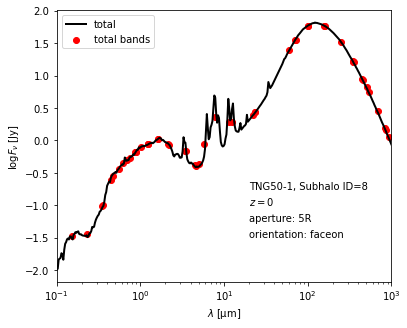

In [6]:
# plot galaxy SED and bands
f, axarr = plt.subplots(1, 1, figsize=(6, 5))
plt.plot(galaxy_sed['wavelength [micron]'],np.log10(galaxy_sed['total flux [Jy]']),c='k', label='total', linewidth=2)
plt.scatter(galaxy_bands.wavelength,np.log10(galaxy_bands.flux),color='r',label='total bands')
plt.xscale('log')
plt.xlabel('$ \lambda \; [\mathrm{\mu m}]$')
plt.text(20,-0.75,f'TNG50-1, Subhalo ID={ID}')
plt.text(20,-1.,'$z=0$')
plt.text(20,-1.25,f'aperture: {aper}')
plt.text(20,-1.5,f'orientation: {ori}')
plt.legend(loc=2)
plt.xlim(1e-1,1e3)
# plt.ylim(-2.,2)
plt.ylabel(r'$\log F_\nu \; [\mathrm{Jy}]$')
plt.show()

### Dust scaling relation

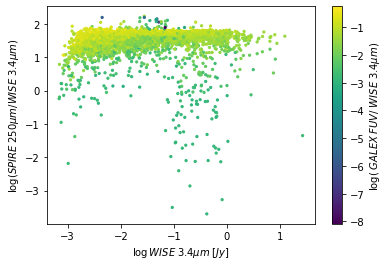

In [23]:
filt = all_galaxies_bands.F_SPIRE_250>0 # remove galaxies without dust emission at 250 microns
plt.scatter(np.log10(all_galaxies_bands.F_WISE_W1[filt]),
            np.log10(all_galaxies_bands.F_SPIRE_250[filt]/all_galaxies_bands.F_WISE_W1[filt]),
            c=np.log10(all_galaxies_bands.F_GALEX_FUV[filt]/all_galaxies_bands.F_WISE_W1[filt]),s=5)
plt.colorbar(label='$\log(\; GALEX\; FUV/ \; WISE \; 3.4 \mu m)$')
plt.xlabel("$ \log WISE \; 3.4 \mu m\; [Jy]$")
plt.ylabel("$ \log (SPIRE \;250 \mu m/ WISE \;3.4 \mu m)$")
plt.show()

### Discover the orientation and aperture effects  

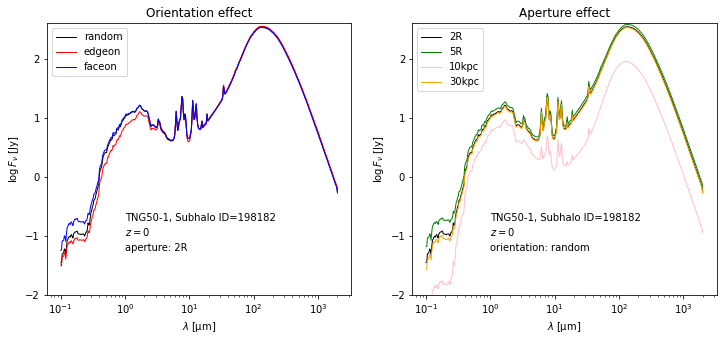

In [24]:
ID = '198182'

aper_fix = '2R'
ori_fix = 'random'

f, axarr = plt.subplots(1, 2, figsize=(12, 5))

# plot different orientations for a fixed aperture
for ori,color in zip(['random','edgeon','faceon'],['k','r','b']):
    with h5py.File(f'/Volumes/SirPuskin/TNG_data/TNG_seds/TNG50_1_seds_z0_{ori}_{aper_fix}.hdf5', 'r') as f:
        galaxy_sed = pd.DataFrame(list(f[ID]),columns=list(f[ID].attrs.values()))  
        axarr[0].plot(galaxy_sed['wavelength [micron]'],
              np.log10(galaxy_sed['total flux [Jy]']),c=color, label=ori, linewidth=1)
        
# plot different apertures for a fixed orientation
for aper,color in zip(['2R','5R','10kpc','30kpc'],['k','g','pink','orange']):
    with h5py.File(f'/Volumes/SirPuskin/TNG_data/TNG_seds/TNG50_1_seds_z0_{ori_fix}_{aper}.hdf5', 'r') as f:
        galaxy_sed = pd.DataFrame(list(f[ID]),columns=list(f[ID].attrs.values()))  
        axarr[1].plot(galaxy_sed['wavelength [micron]'],
              np.log10(galaxy_sed['total flux [Jy]']),c=color, label=aper, linewidth=1)

for ax in axarr.flat:
    ax.set_xscale('log')
    ax.set_ylim(-2,2.6)
    ax.set_xlabel('$ \lambda \; [\mathrm{\mu m}]$')
    ax.set_ylabel(r'$\log F_\nu \; [\mathrm{Jy}]$')
    ax.legend(loc=2)
    ax.text(1,-1.,'$z=0$')
    ax.text(1,-0.75,f'TNG50-1, Subhalo ID={ID}')

axarr[0].text(1,-1.25,f'aperture: {aper_fix}')
axarr[1].text(1,-1.25,f'orientation: {ori_fix}')
axarr[0].set_title('Orientation effect')
axarr[1].set_title('Aperture effect')

plt.show()

# TNG to SKIRT (mass to light) 

The script presented below generates the SKIRT configuration file for an arbitrary TNG galaxy. Running the unchanged script will produce the SKIRT file used to generate galaxy SED and fluxes presented in Trcka et al. (2022). That is, SKIRT will produce the galaxy SED (UV-summm) and fluxes in 53 broadbands, for 3 orientations (random, face-on, edge-on) and within 4 apertures (10kpc, 30kpc, 2$\cdot R_{1/2}$ and 5$\cdot R_{1/2}$), as explained below.


SKIRT_template.ski file is a template needed to generate the SKIRT configuration file. <br>
To find out more on how to create/modify configuration files check SKIRT <a href="https://skirt.ugent.be/version9/_tutorials.html">tutorials</a>. <br>

The details about importing cosmological simulation snapshot data can be found <a href="https://skirt.ugent.be/skirt9/_hydro_import.html">here</a> <br>


There are 2 types of assumptions in the template: <b>fixed</b> and <b>variable</b>. <br> 


The <b>fixed</b> assumptions cannot be changed with the script below as they are at the core of the model applied in Trcka et al. (2022), and their change can produce different final results. 
The fixed assumptions are: <br>
- IMF: <a href="https://iopscience.iop.org/article/10.1086/376392">Chabrier (2003)</a> <br>
- Evolved stellar populations model: <a href="https://ui.adsabs.harvard.edu/abs/2003MNRAS.344.1000B/abstract">  Bruzual & Charlot (2003) </a><br>
- Star-forming regions model: MAPPINGSIII (<a href="https://iopscience.iop.org/article/10.1086/528711">Groves et al. 2008</a>). Stars younger than 1e7 years are considered young.<br>
- Diffuse dust model: THEMIS (<a href="https://www.aanda.org/articles/aa/full_html/2017/06/aa30225-16/aa30225-16.html">Jones et al. 2017</a>) <br>
- All source data (evolved and young stellar populations) reside inside the spherical aperture with $R=5\cdot R_{1/2}$ from the galaxy center of mass, where $R_{1/2}$ is the galaxy half mass radius. The particles further away should be removed.
- Only the dust cells inside a cube with the side of $10\cdot R_{1/2}$ are kept. The cube is selected to preserve the original Voronoi grid. The cells further away should be removed.
 - It is assumed that the source and dust coordinates are transformed so that the coordinate system origin at the galaxy center of mass. <br>


The <b>variable</b> assumptions are listed below, and their change is sometimes needed (e.g. a galaxy ID should be unique for each galaxy) and sometimes optional (e.g. if the User wants to experiment with the number of photon packets, or if not all apertures are needed, some can be removed etc.). If not mentioned otherwise, the default values are used in Trcka et al. (2022), and if not used, the results may not be reproduced.

## Selecting variable assumptions
<u><b>General:</b></u><br>
<b>numPackets</b> - Number of photon packets (optional change). The default value is 5e7. <br>

<u><b>Cosmology:</b></u><br>
<b>redshift</b> - The redshift z of the model coordinate frame (change needed/optional - should correspond to the galaxy redshift. In the script it is assumed that z=0).<br>

<u><b>File names:</b></u><br>
The expected columns in the files are listed <a href="https://skirt.ugent.be/skirt9/_hydro_import.html">here</a> and following the links therein. <br>
<b>stars_file_name</b> - The name of the file containing data for the evolved stellar populations (change needed. In the script it is assumed the name is 'stars.txt'). <br> 
<b>dust_file_name</b> - The name of the file containing data for the diffuse dust (change needed. In the script it is assumed the name is 'dust.txt'). <br> 
<b>sfr_file_name</b> - The name of the file containing data for the young stellar populations (change needed. In the script it is assumed the name is 'sfr.txt'). <br> 

     
<u><b>Dust properties:</b></u><br>
<b>f_dust</b> - The fraction of metals locked up in dust (optional change). The default is 0.3 <br>
<b>tau</b> - This parameter describes how covered the star-forming regions are with the PDR. Here it is only used to name the file (optional change. For completeness it should correspond to the value used for the creation of 'sfr.txt' file. The default is "3").<br>



<u><b>Galaxy properties</b></u> (should be changed for every galaxy):<br>
<b>gid</b> -  The galaxy ID (change needed - should be unique for every galaxy. This information is only used to name the ski file.)<br>
<b>angles</b> - The <a href="https://skirt.ugent.be/skirt9/class_distant_instrument.html">angles</a> to orient the instrument (change needed - in general, should be unique for every galaxy). The default is [0,0,0]. Depending on the desired orientation (see below), if using the default value the results from Trcka et al. 2022 may not be reproduced.<br> 
<b>R12</b> -  The galaxy stellar half mass radius, in pc (change needed. Used to calculate the medium grid size and the instrument apertures. The default is 1000. Since this value is just a placeholder, using it will not reproduce the results from Trcka et al. 2022.)<br>

<u><b>Medium properties:</b></u><br>
<b>minX, maxX, minY, maxY, minZ, maxZ</b> - The boundaries of the medium Voronoi grid (optional change. $5\cdot R_{1/2}$ is the default).<br>

<u><b>Instruments:</b></u><br>
<b>SED</b> - The instrument that collects flux contribution in 450 wavelength bins from 0.2 to 2000 microns (optional change. By default not selected.). <br>
<b>band</b> - The instrument that collects flux contribution in 53 broad-bands<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1) (needed change. By default not selected.). <br>
<u>Note</u>: No instrument is selected by default. One or both from above should be selected in order to run SKIRT and to reproduce results from Trcka et al. (2022). <br>


<b>distance</b> - The galaxy distance to the instrument. If the redshift is z>0 the fluxes are calculated in both observed and rest frame. For the former, the distance is calculated based on the input redshift, while for the latter the distance should be provided (optional change. The default is 20Mpc).<br>
<b>statistics</b> - Whether or not to record the information intended for calculating <a href="https://skirt.ugent.be/skirt9/class_flux_recorder.html">statistical</a> properties of the results (optional change. The default is "true").

<u><b>Additional apertures:</b></u><br>
By default an instrument will collect all light that comes to it. If the default settings are applied, this would correspond to the aperture of $5\cdot R_{1/2}$. Beside this, a set of additional apertures is possible: <br>
<b>2R</b> - Corresponds to the circular aperture with $R=2\cdot R_{1/2}$ <br>
<b>10</b> - Corresponds to the circular aperture with $R=10 kpc$ <br>
<b>30</b> - Corresponds to the circular aperture with $R=30kpc$ <br>


<u><b>Orientations:</b></u><br>

<b>or</b> - The orientation depends on the coordinates of the input data (stars, sfr and dust) and the input angles. If the input galaxy data corresponds to the original orientation from the simulation, setting angles to (0,0,0) will result in the instrument observing galaxy from the original orientation. As this orientation is different for every galaxy, this approach will provide the most realistic results. This corresponds to the random orientation from Trcka et al. (2022). To capture light from specific orientation such as face-on and edge-on view, the angles have to be adjusted. <br>

<a name="cite_note-1"></a>1. [^](#cite_ref-1) see table at the beginning of this document

In [14]:
import xml.etree.ElementTree as ET
import datetime

In [10]:
class SKIRT_arguments:
    path_to_SKIRT_template = './SKIRT_template.ski'
  
    # General
    numPackets = 5e7

    # Cosmology
    redshift = 0

    # Dust properties
    f_dust = 0.2
    tau = '3' #  tau = ''  if the galaxy has no star forming regions
        
    # Galaxy information
    def __init__(self, 
                 gid='ID', 
                 angles=None, 
                 R12=1000, 
                 stars_file_name='stars.txt', 
                 dust_file_name='dust.txt', 
                 sfr_file_name='sfr.txt',
                 additional_apertures=None,
                 instruments=None,
                ):
        self.gid : str = gid
        self.angles : list = [0,0,0] if angles is None else angles
        self.R12 : float = R12 
        self.stars_file_name = stars_file_name
        self.dust_file_name = dust_file_name
        self.sfr_file_name = sfr_file_name
        self.additional_apertures = [] if additional_apertures is None else additional_apertures
        self.instruments = [] if instruments is None else instruments  
        
    # Medium properties
    @property
    def minX(self): return -self.R12 * 5
    @property
    def maxX(self): return self.R12 * 5    
    
    minY = minX
    minZ = minX
    maxY = maxX
    maxZ = maxX
    
    # Instruments
    distance = '20 Mpc'
    
    # Statistics
    record_stat = 'true'


## Example for the TNG50-1 galaxy with ID=8


In [19]:
galaxy = SKIRT_arguments(
    gid='8',
    R12=4802.73,
    stars_file_name='NRstars_best_a5_8.txt',
    dust_file_name='NRdust_best_a5_8.txt',
    sfr_file_name='NRsfr_best_a5_t3_8.txt', # Use sfr_file_name = '' if the galaxy has no star forming regions,
    additional_apertures = ['2R','10','30'], # All apertures are selected
    angles = [123.86,-123.72,50.14],
    instruments = ['SED','band'], # All instruments are selected
)

In [20]:
def generate_ski_file(galaxy):
    ski = ET.parse(galaxy.path_to_SKIRT_template)
    root = ski.getroot()
    root.set('producer', 'TNG_SKIRT_doc')
    root.set('time', str(datetime.datetime.now()))
    
    sim = root.findall('MonteCarloSimulation')[0]
    
    sim.set('numPackets',str(galaxy.numPackets))
    
    # Redshift
    sim.findall('cosmology')[0].findall('FlatUniverseCosmology')[0].set('redshift',str(galaxy.redshift))
    
    # Sources
    for sources in sim.iter('sources'):
        for source in sources.findall('ParticleSource'): 
            if source.attrib['filename']=='stars.txt':
                source.set('filename', galaxy.stars_file_name)  
            if source.attrib['filename']=='sfr.txt':
                if galaxy.sfr_file_name:
                    source.set('filename', galaxy.sfr_file_name)  
                else: 
                    sources.remove(source) # If there are no star-forming regions, this line removes them from the ski file
    # Medium
    medium = sim.findall('mediumSystem')[0].findall('MediumSystem')[0]
    dust = medium.findall('media')[0].findall('VoronoiMeshMedium')[0]
    dust.set('filename', galaxy.dust_file_name)
    dust.set('massFraction',str(galaxy.f_dust))
    dust.set('minX', f'{galaxy.minX} pc')
    dust.set('maxX', f'{galaxy.maxX} pc')
    dust.set('minY', f'{galaxy.minY} pc')
    dust.set('maxY', f'{galaxy.maxY} pc')  
    dust.set('minZ', f'{galaxy.minZ} pc')
    dust.set('maxZ', f'{galaxy.maxZ} pc')
    
    # Grid
    grid = medium.findall('grid')[0].findall('PolicyTreeSpatialGrid')[0]
    grid.set('minX', f'{galaxy.minX} pc')
    grid.set('maxX', f'{galaxy.maxX} pc')
    grid.set('minY', f'{galaxy.minY} pc')
    grid.set('maxY', f'{galaxy.maxY} pc')  
    grid.set('minZ', f'{galaxy.minZ} pc')
    grid.set('maxZ', f'{galaxy.maxZ} pc')
     
    instruments = sim.findall('instrumentSystem')[0].findall('InstrumentSystem')[0].findall('instruments')[0]

    for instrument in instruments.findall('SEDInstrument'):
        if (galaxy.redshift==0) and (instrument.attrib['instrumentName'].find('obs')>-1):
            instruments.remove(instrument) # remove instruments for high redshift
        for aper in ['2R', '10', '30']:
            if (aper not in galaxy.additional_apertures ) and (instrument.attrib['instrumentName'].find(aper)>-1):
                if instrument in instruments:
                    instruments.remove(instrument) # remove unused apertures 
        for instr in ['SED', 'band']:
            if (instr not in galaxy.instruments) and (instrument.attrib['instrumentName'].find(instr)>-1):
                if instrument in instruments:
                    instruments.remove(instrument) # remove unused instruments 
    for instrument in instruments.findall('SEDInstrument'):
        if (instrument.attrib['distance'].find('dist_z0_Mpc')>-1):
            instrument.set('distance', f'{galaxy.distance}')
        if (instrument.attrib['inclination'].find('OrI')>-1):
            instrument.set('inclination', f'{galaxy.angles[0]} deg')
        if (instrument.attrib['azimuth'].find('OrA')>-1):
            instrument.set('azimuth', f'{galaxy.angles[1]} deg')
        if (instrument.attrib['roll'].find('OrR')>-1):
            instrument.set('roll', f'{galaxy.angles[2]} deg')
        if (instrument.attrib['radius'].find('2R12')>-1):
            instrument.set('radius', f'{galaxy.R12} pc')
        instrument.set('recordStatistics', f'{galaxy.record_stat}')

    ski.write(f'SKIRT_fdust{str(galaxy.f_dust).replace(".","")}_t{galaxy.tau}_{galaxy.gid}.ski',
              encoding='UTF-8',xml_declaration=True) 
    print(f'SKIRT_fdust{str(galaxy.f_dust).replace(".","")}_t{galaxy.tau}_{galaxy.gid}.ski is generated')

In [21]:
generate_ski_file(galaxy)

SKIRT_fdust02_t3_8.ski is generated
